<a href="https://colab.research.google.com/github/ma2sevich222/study_projects/blob/main/person_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
pip install MTCNN # Устанавливаем детектор лиц

     |████████████████████████████████| 2.3MB 2.8MB/s 


#импортируем библиотеки

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
import os, random
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
import numpy as np
from numpy import argmax
from keras.models import load_model
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import metrics
%matplotlib inline

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##функция распознования лиц и превращение в векторы

In [ ]:
def extract_face(filename, required_size=(160, 160)):
    
	# загружаем картинки
    
    image = Image.open(filename)
    image = image.convert('RGB')
    
	# конвертируем в масив
    
    pixels = asarray(image)
	# создаем детектор лиц
    
    detector = MTCNN()
    
	# определяем лица
    
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
	# берем лицо из картинки
    face = pixels[y1:y2, x1:x2]
	
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

##функция загрузки лиц

In [ ]:
def load_faces(directory):
	faces = list()
	for filename in listdir(directory):
		path = directory + filename
		face = extract_face(path)
		# сохраняем лицо
		faces.append(face)
	return faces

##функция загрузки данных

In [ ]:
# функция загрузки датасета
def load_dataset(directory):
	X, y = list(), list()
	# пробегаемся по папкам классов
	for subdir in listdir(directory):
		
		path = directory + subdir + '/'
		
		if not isdir(path):
			continue
		# загружаем лица в суб директорию
		faces = load_faces(path)
		# классы
		labels = [subdir for _ in range(len(faces))]
		
		print('>загружено %d фотографий для класса: %s' % (len(faces), subdir))
		# сохраняем
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [ ]:
# загружаем обучающий сет
trainX, trainy = load_dataset('/content/drive/My Drive/newfacesdata/train/')
print(trainX.shape, trainy.shape)

 # загружаем проверочный сет
testX, testy = load_dataset('/content/drive/My Drive/newfacesdata/test/')
# сохраняем масивы в один файл
savez_compressed('facedatasat.npz', trainX, trainy, testX, testy)











>загружено 5 фотографий для класса: helen_0074
>загружено 5 фотографий для класса: niv1604
>загружено 5 фотографий для класса: al_men_duke
>загружено 5 фотографий для класса: burketsovi
>загружено 5 фотографий для класса: oseledetsproduction
>загружено 5 фотографий для класса: killa_inky
>загружено 5 фотографий для класса: kolyanizotov
>загружено 5 фотографий для класса: odeebang
>загружено 5 фотографий для класса: kr1ger
>загружено 5 фотографий для класса: pavel
>загружено 5 фотографий для класса: anutich83
>загружено 5 фотографий для класса: natayakim
>загружено 5 фотографий для класса: ezcape
>загружено 5 фотографий для класса: shtuka_ivan
>загружено 5 фотографий для класса: lutcenko_roman
>загружено 5 фотографий для класса: evgeny
>загружено 5 фотографий для класса: ruslan
>загружено 5 фотографий для класса: viktor.thefirst
>загружено 5 фотографий для класса: yulyana
(95, 160, 160, 3) (95,)
>загружено 2 фотографий для класса: oseledetsproduction
>загружено 2 фотографий дл

##функция превращения в embedding векторы

In [ ]:
def get_embedding(model, face_pixels):
	# масшатбируем пиксельные данные
	face_pixels = face_pixels.astype('float32')
	
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	
	samples = expand_dims(face_pixels, axis=0)
	# получаем embedding вектор
	yhat = model.predict(samples)
	return yhat[0]

In [ ]:
# загружаем лица
    
data = load('facedatasat.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Загруженны данные размером: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# загружаем  facenet модель

model = load_model('/content/drive/My Drive/facenet_keras.h5')
print('Сеть загруженна')

# получаем embedding вектора в обучающем сете
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

Загруженны данные размером:  (95, 160, 160, 3) (95,) (38, 160, 160, 3) (38,)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Сеть загруженна
(95, 128)


In [ ]:
# получаем embedding вектора в проверочном сете

newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# сохраняем все данные
savez_compressed('facedatasat.npz-embeddings.npz', newTrainX, trainy, newTestX, testy)

(38, 128)


In [ ]:
# загружаем
data = load('facedatasat.npz-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# нормализуем
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# кодируем лэйблы
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

Dataset: train=95, test=38


#Финальная сеть

In [ ]:
model1=Sequential()
model1.add(Dense(100,activation='relu',input_dim=128))
model1.add(Dense(200,activation='relu'))
model1.add(Dense(19,activation='sigmoid'))

In [ ]:
model1.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history=model1.fit(trainX,trainy, epochs=20)

Epoch 1/20
95/95 [==============================] - 12s 126ms/step - loss: 2.9355 - sparse_categorical_accuracy: 0.0947
Epoch 2/20
95/95 [==============================] - 0s 403us/step - loss: 2.8893 - sparse_categorical_accuracy: 0.4632
Epoch 3/20
95/95 [==============================] - 0s 283us/step - loss: 2.8484 - sparse_categorical_accuracy: 0.7158
Epoch 4/20
95/95 [==============================] - 0s 283us/step - loss: 2.8078 - sparse_categorical_accuracy: 0.8105
Epoch 5/20
95/95 [==============================] - 0s 222us/step - loss: 2.7607 - sparse_categorical_accuracy: 0.8737
Epoch 6/20
95/95 [==============================] - 0s 224us/step - loss: 2.7096 - sparse_categorical_accuracy: 0.8842
Epoch 7/20
95/95 [==============================] - 0s 235us/step - loss: 2.6515 - sparse_categorical_accuracy: 0.8737
Epoch 8/20
95/95 [==============================] - 0s 246us/step - loss: 2.5841 - sparse_categorical_accuracy: 0.9474
Epoch 9/20
95/95 [=============================

In [ ]:
test_loss, test_acc = model1.evaluate(testX,testy, verbose=2)

print('\nТочность на проверочных данных:', test_acc)


Точность на проверочных данных: 0.8421052600208082


##функция получения embedding вектора для проверочной фотографии

In [ ]:
def get_embedding_unk(model, face_unk):
	face_unk = face_unk.astype('float32')
	mean, std = face_unk.mean(), face_unk.std()
	face_unk = (face_unk - mean) / std
	sample = expand_dims(face_unk, axis=0)
	yhat = model.predict(sample)
	return yhat[0]

In [ ]:
unknown='/content/drive/My Drive/unknow.jpg' #путь к фотографии для проверки
#!!!!!добавить вывод изображения!!!!

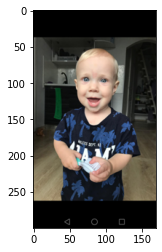

C веротностью 79.079857 процентов это ruslan
ruslan


In [ ]:
#извлекаем вектор лица и превращаем в embedding
face_unk=extract_face(unknown,required_size=(160,160))
emb_unkn=get_embedding_unk(model,face_unk)



#загружаем в сеть
person=model1.predict(emb_unkn.reshape(1,-1))
#считаем вероятность
proba=max(person.reshape(-1,1))*100
#получаем имя класса
name=out_encoder.inverse_transform(np.argmax(person.reshape(-1,1),axis=0))[0]

folder='/content/drive/My Drive/newfacesdata/test/%s' % (name)

#выводим случайную картинку класса который определила сеть
a=random.choice(os.listdir(folder))
file = folder+'/'+a
im=Image.open(file)
size = 300, 300
im.thumbnail(size)


if proba>75.0:
  

  plt.imshow(im)
  plt.show()
  print('C вероятностью %f процентов это % s'% (proba[0],name))

  
else:
  print('Данный человек отсутствует в базе')
